In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.tensorflow.data import _parse_function

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/te

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

# the nightly build of tensorflow_probability is required as of the time of writing this 
import tensorflow_probability as tfp
ds = tfp.distributions

In [5]:
print(tf.__version__, tfp.__version__)

2.0.0-beta1 0.7.0-dev20190510


In [6]:
TRAIN_SIZE=101726
BATCH_SIZE=128
TEST_SIZE=10000
DIMS = (128, 128, 1)
N_TRAIN_BATCHES =int((TRAIN_SIZE-TEST_SIZE)/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_SIZE/BATCH_SIZE)
TRAIN_BUF = 1000
TEST_BUF = 1000

In [7]:
record_loc = DATA_DIR / 'tfrecords' / "starling.tfrecords"

In [8]:
# read the dataset
raw_dataset = tf.data.TFRecordDataset([record_loc.as_posix()])

In [9]:
data_types = {
    "spectrogram": tf.uint8,
    "index": tf.int64,
    "indv": tf.string,
}

In [10]:
# parse each data type to the raw dataset
dataset = raw_dataset.map(lambda x: _parse_function(x, data_types=data_types))

In [11]:
spec, index, indv  = next(iter(dataset))

In [12]:
train_dataset = dataset.skip(TEST_SIZE).take(TRAIN_SIZE-TEST_SIZE).shuffle(TEST_BUF).batch(BATCH_SIZE)

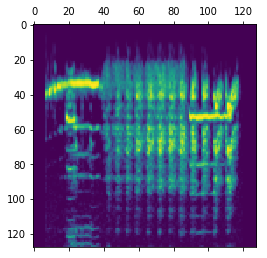

In [13]:
plt.matshow(spec.numpy().reshape(128,128))

In [14]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir
ensure_dir(FIGURE_DIR / 'networks' / 'starling128')

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [15]:
#gen_func =  model.decode
interp_len = 5

In [16]:
dset_iter = iter(dataset)
x1 = np.reshape(next(dset_iter)[0] / 255, (1,128,128,1))
x2 = np.reshape(next(dset_iter)[0] / 255, (1,128,128,1))
x3 = np.reshape(next(dset_iter)[0] / 255, (1,128,128,1))
exdat = np.vstack([x1, x2, x3])

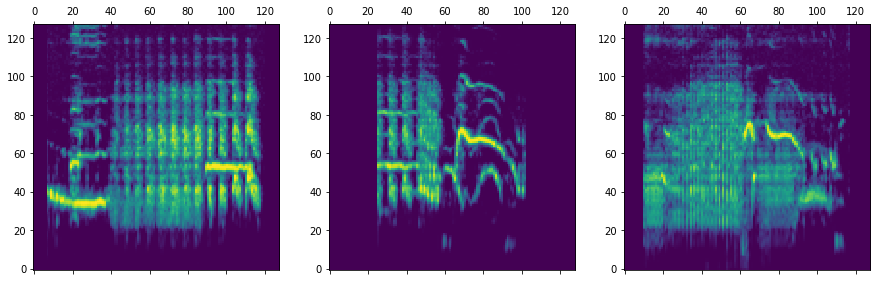

In [17]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs[0].matshow(np.squeeze(x1), origin='lower')
axs[1].matshow(np.squeeze(x2), origin='lower')
axs[2].matshow(np.squeeze(x3), origin='lower')

In [18]:
N_Z = 128

In [19]:
all_x = []
for batch, train_x in tqdm(
    zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
):
    x = train_x[0]
    all_x.append(x)
all_x = np.concatenate(all_x)
all_x = np.reshape(all_x, [len(all_x)] + list(DIMS[:2]))

In [23]:
np.shape(all_x)

(91648, 128, 128)

In [20]:
ensure_dir(DATA_DIR / 'starling_128_numpy')

In [21]:
np.save(DATA_DIR / 'starling_128_numpy' / 'all_specs', all_x)

In [22]:
np.save(DATA_DIR / 'starling_128_numpy' / 'j-points', [x1, x2, x3])

### J diagram direct

In [31]:
#pt1x,pt2x,pt3x =gen_func(tf.stack([pt1,pt2,pt3]))
#get proportions
x_list = []
for ci, C in enumerate(np.linspace(0, 1, interp_len)):
    for bi, B in enumerate(np.linspace(0, 1, interp_len)):
        A = 1 - C - B
        x_list.append(
            C * x1 +
            B * x2 + 
            A * x3
        )
x_list = np.vstack(x_list)

In [32]:
np.shape(x_list)

(25, 128, 128, 1)

In [33]:
# make diagram
Jdiagram = np.ones((x_list.shape[1]*(interp_len), x_list.shape[2]*(interp_len+2), x_list.shape[3]))
np.shape(Jdiagram)

(640, 896, 1)

In [34]:
#populate
i = 0
for ci, C in enumerate(np.linspace(0, 1, interp_len)):
    for bi, B in enumerate(np.linspace(0, 1, interp_len)):
        Jdiagram[(interp_len -1 - bi)*x_list.shape[1]:((interp_len - bi))*x_list.shape[1], (ci+1)*x_list.shape[2]:(ci+2)*x_list.shape[2], :] = x_list[i]
        i+=1
Jdiagram[(interp_len - 1)*x_list.shape[1]: (interp_len)*x_list.shape[1], 
        :x_list.shape[2], :] = x3

Jdiagram[(interp_len - 1)*x_list.shape[1]: (interp_len)*x_list.shape[1], 
        (interp_len +1)*x_list.shape[2]: (interp_len+2)*x_list.shape[2] , :] = x1

Jdiagram[: x_list.shape[1], 
        :x_list.shape[2], :] = x2

(array([1.57000e+02, 1.78100e+03, 3.02760e+04, 3.11779e+05, 8.22980e+04,
        2.79590e+04, 1.18803e+05, 3.27000e+02, 5.10000e+01, 9.00000e+00]),
 array([-0.79215688, -0.52941177, -0.26666667, -0.00392157,  0.25882353,
         0.52156863,  0.78431373,  1.04705883,  1.30980393,  1.57254903,
         1.83529413]),
 <a list of 10 Patch objects>)

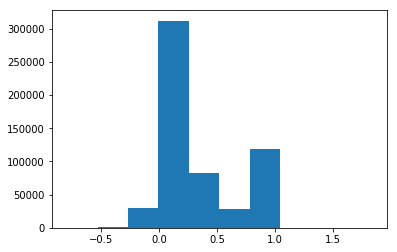

In [36]:
plt.hist(Jdiagram.flatten());

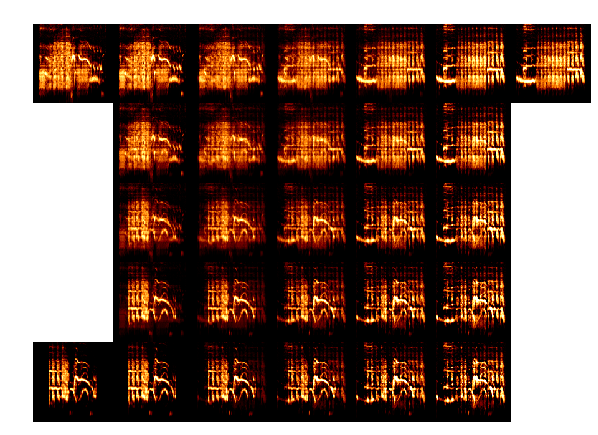

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(np.squeeze(Jdiagram), vmin = 0, vmax=1, cmap=plt.cm.afmhot, origin = 'lower')
ax.axis('off')
save_fig(FIGURE_DIR / 'networks' / 'starling128'/ ('linear_JDiagram_128'), dpi=300, save_jpg=True)

(-0.5, 895.5, -0.5, 639.5)

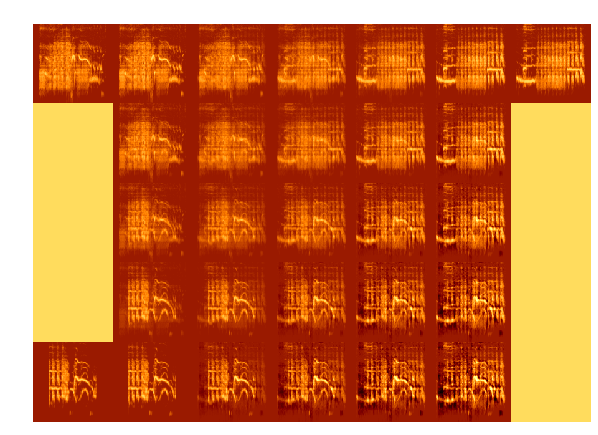

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
#ax.matshow(np.squeeze(Jdiagram), vmin = 0, vmax=1, cmap=plt.cm.afmhot, origin = 'lower')
ax.matshow(np.squeeze(Jdiagram), cmap=plt.cm.afmhot, origin = 'lower')
ax.axis('off')
#save_fig(FIGURE_DIR / 'networks' / 'starling128'/ ('linear_JDiagram_128'), dpi=300, save_jpg=True)